In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
pdb='/Users/paulrobustelli/Desktop/CHEM.101.6/Lab4_VillinFOlding/Villin_Traj/All-atom/2F4K.protein.pdb'
trajectory='/Users/paulrobustelli/Desktop/CHEM.101.6/Lab4_VillinFOlding/Villin_Traj/All-atom/2F4K.protein.s10.dcd'
xray_CA_pdb='/Users/paulrobustelli/Desktop/CHEM.101.6/Lab4_VillinFOlding/Villin_Traj/All-atom/2f4K.xray.CA.pdb'
outdir='/Users/paulrobustelli/Desktop/CHEM.101.6/Lab4_VillinFOlding/Villin_Traj/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /Users/paulrobustelli/Desktop/CHEM.101.6/Lab4_VillinFOlding/Villin_Traj/output
pdb: /Users/paulrobustelli/Desktop/CHEM.101.6/Lab4_VillinFOlding/Villin_Traj/All-atom/2F4K.protein.pdb
trjaectory: /Users/paulrobustelli/Desktop/CHEM.101.6/Lab4_VillinFOlding/Villin_Traj/All-atom/2F4K.protein.s10.dcd


In [3]:
stride_sel=10
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [64]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 6280

Starting frame: 0

Last frame: 6280

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA

In [4]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [5]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [6]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


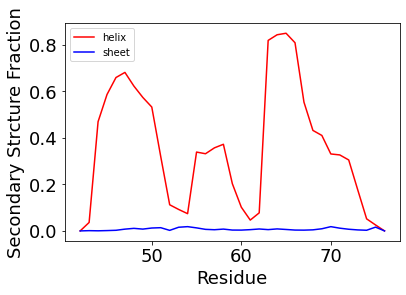

In [7]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [8]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [9]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [12]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




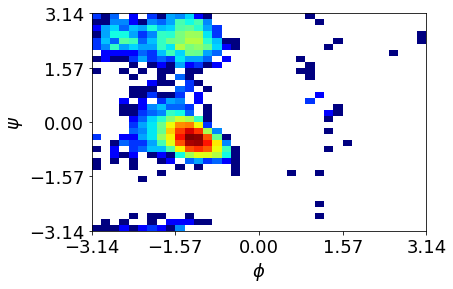

In [13]:
plot_phipsi(45)


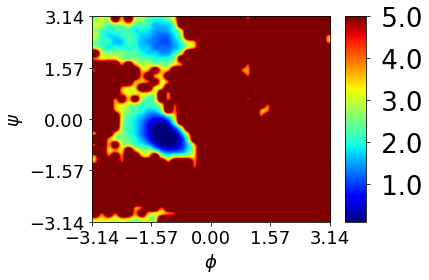

In [14]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],normed=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(45)

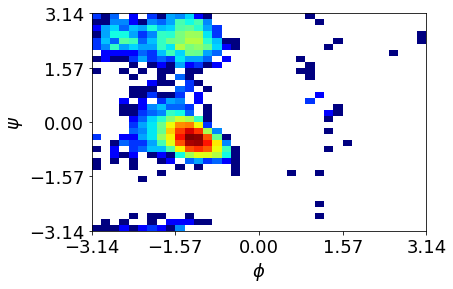

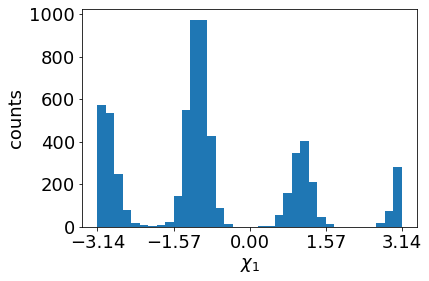

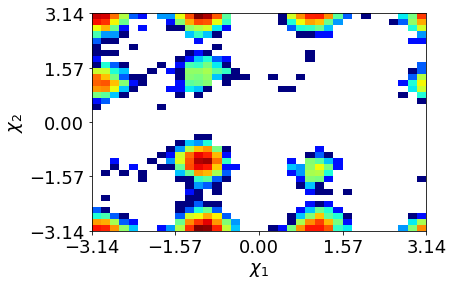

In [15]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [16]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [17]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 6280 frames, 35 atoms, 35 residues, and unitcells at 0x7fd597356c40>

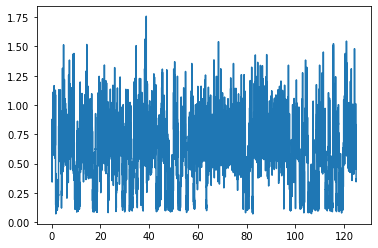

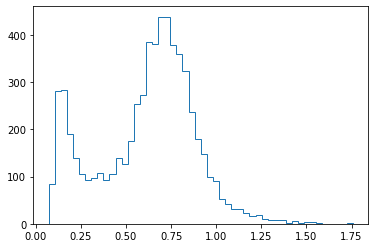

In [18]:
CA_trj_sel=trj.topology.select("name CA")
CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

In [19]:
native_frames=np.where(rmsd<0.25)[0]
len(native_frames)


1016

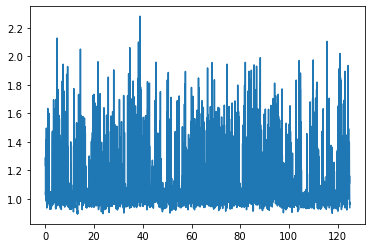

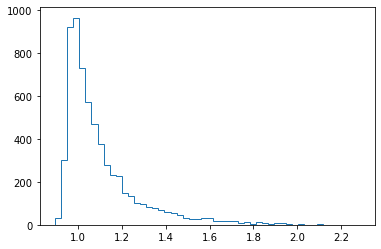

In [20]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [21]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(6280, 2)


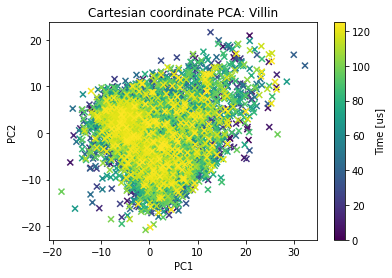

In [22]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

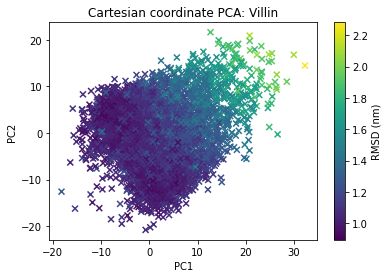

In [23]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

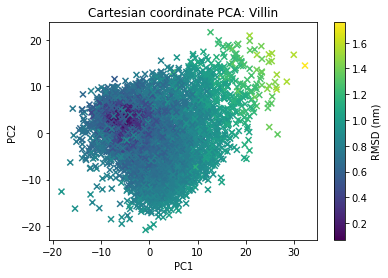

In [24]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

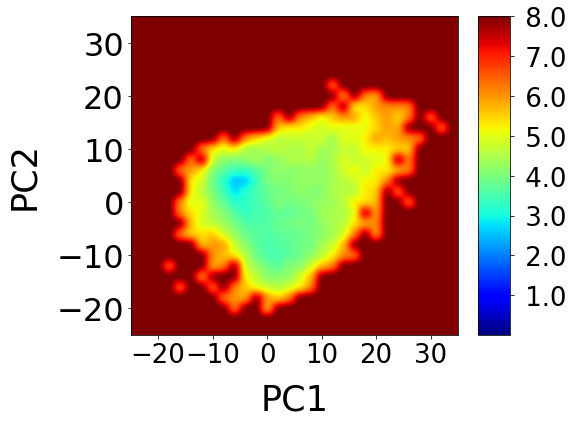

In [25]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [26]:
#Lets Plot Free Energies as a function of RMSD and Rg


*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

In [28]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [29]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

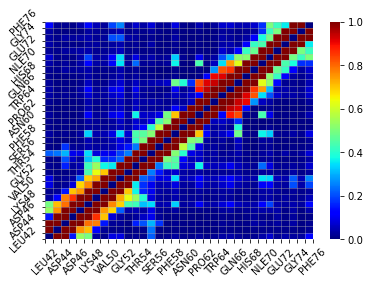

In [30]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [31]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [32]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [33]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

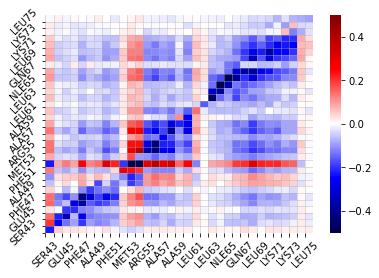

In [34]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

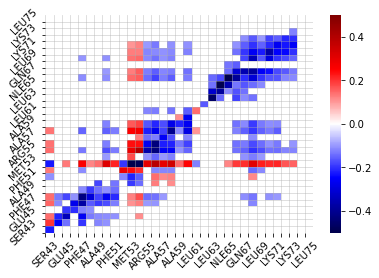

In [35]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

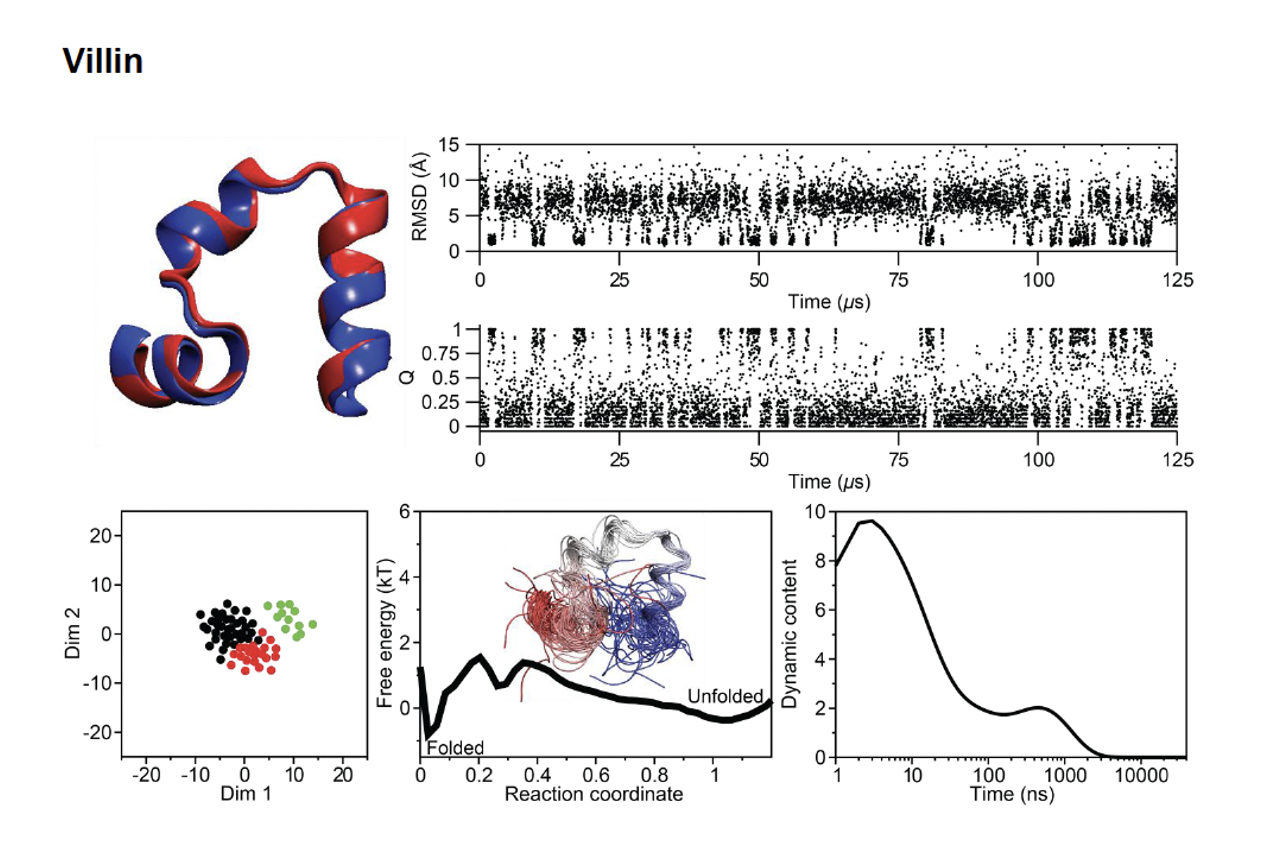

First we need to determine the native contacts and calculate Q

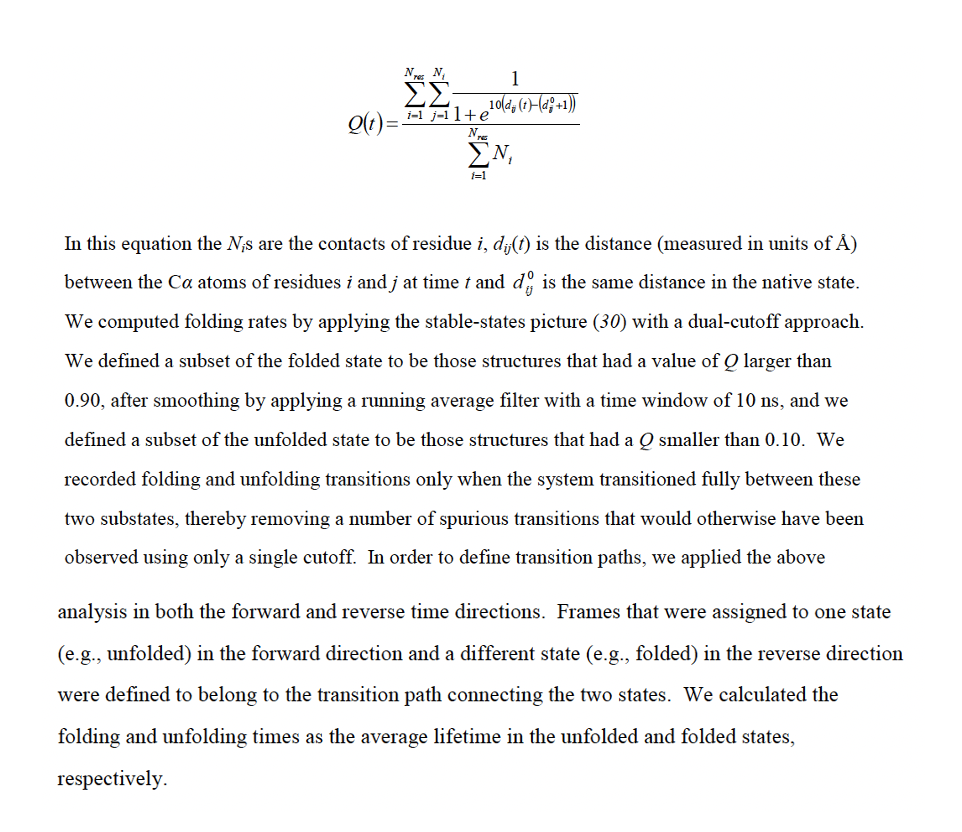

In [36]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x7fd5e0c484c0>

In [37]:
#Lets Make a 1D array that contains all native distances pairs:
native_distance_matrix1D=[]
#QUESTION: How can you make a 1D Array that only contains distances between residue pairs seperated by more than 7 residuyes



#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [38]:
#Now lets do the same thing for our trajectory, making an array that is contacts vs. #frames in the trajectory

traj_CA_distance_matrix1D=[]


#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10

    


In [48]:
#Make Sure that For each Distance you can compare that native distance to the trajectory distance 


In [40]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory



In [41]:
#Write a function to Calculate Q 


In [42]:
#Plot Q and a Histogram


In [43]:
#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q
native_frames

array([  79,   80,   81, ..., 6007, 6009, 6011])

In [565]:
#Select Only the Frames with low RMSD from native state for the native distances


(702, 1016)

In [44]:
#Filter the native distances to only include distances where the average value < 10A in the native frames 


In [45]:
#Check that we're comparing all the correct distances 


In [46]:
#Plot Q using only our native frames


In [47]:
#Lets Calculate Our Transition Paths using the Dual Cutoff Approach 

In [ ]:
#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations
